In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score


import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
import librosa
from tqdm import tqdm
from scipy.stats import skew

# Classical Music Analysis and Classification Project

## Project Overview

This project aims to explore, analyze, and classify classical music in comparison to other music genres using a combination of data analysis, audio signal processing, machine learning, and computer vision techniques. The goal is to showcase skills in data collection, exploratory data analysis (EDA), feature engineering, deep learning, and visual interpretation of music both in audio and sheet music formats.


## Scientific Method Approach

1. **Observation**  
   Classical music is often said to have distinct acoustic and structural characteristics compared to other genres such as pop, rock, and rap.  
   
2. **Question**  
   Can we identify classical music tracks and composers automatically using audio features? How does classical music differ statistically from other genres? Can we classify sheet music images by composer or style?

3. **Hypothesis**  
   Classical music exhibits unique patterns in tempo, frequency, and structure that can be distinguished by machine learning models from other music genres. Moreover, computer vision techniques can recognize composers or styles from sheet music images.

4. **Experiment**  
   - Collect and analyze tabular music datasets to find statistical differences between classical and other genres.  
   - Train audio classifiers on spectrograms to identify classical music and composers.  
   - Apply clustering to explore genre and composer groupings.  
   - Use computer vision on sheet music images for composer classification and score interpretation.

5. **Analysis**  
   Evaluate model performance using accuracy, confusion matrices, and visualization techniques. Examine clustering results for meaningful patterns. Analyze computer vision classifier effectiveness.

6. **Conclusion**  
   Draw conclusions on the distinctiveness of classical music, the feasibility of audio-based genre and composer classification, and the potential of computer vision to understand music scores. Suggest future improvements or applications.


## Project Plan and Steps

### 1. Data Collection and Exploratory Data Analysis (EDA)
- Collect music metadata (genre, tempo, loudness, etc.) from Spotify or public datasets.  
- Visualize and compare classical music characteristics versus other genres.

### 2. Transcription Pipeline
- Preprocess audio clips into spectrograms.  
- Build and train classifiers to transcript music

### 3. Composer Classification from Audio
- Prepare labeled datasets of composers (e.g., Beethoven, Mozart).  
- Train multi-class classifiers to predict the composer from audio features.

### 4. Clustering and Visualization
- Perform dimensionality reduction (PCA, t-SNE) on audio features.  
- Cluster and visualize genres and composers to discover latent structures.

### 5. Sheet Music Computer Vision
- Collect and preprocess sheet music images.  
- Train CNNs to classify composer or style from sheet music.  
- Explore OCR techniques for score transcription.



## Expected Outcomes

- Comprehensive understanding of classical music’s unique audio features.  
- Functional genre and composer classifiers with quantifiable accuracy.  
- Meaningful clusters of musical styles and composers.  
- Prototype sheet music analysis tool using computer vision.


## Technologies and Tools

- Python, Pandas, Matplotlib/Seaborn for data analysis and visualization  
- Librosa for audio processing  
- TensorFlow / PyTorch for deep learning models  
- Scikit-learn for clustering and evaluation  
- OpenCV, EasyOCR for sheet music computer vision  
- Jupyter Notebooks for experimentation and documentation


## References and Datasets

- Mini-MusicNet dataset (audio clips and labels)  
- Spotify public datasets or Kaggle genre metadata  


*This project combines data science, machine learning, and computer vision to deeply understand and classify classical music, providing a strong showcase of interdisciplinary technical skills.*


## Music transcription

To begin with, I am going to use a dataset that contains classical music. It is probably the easiest to transcribe into notes. We are going to begin by getting some data. The source I am using is from Mini MusicNet since the big MusicNet contains a huge amount of data that would require a lot of computational power and time.

Let us explain how our data looks like. We have a lot of data points, 82,500 samples to be exact. Each of them has 4096 features. We expect those 4096 features to be the **raw amplitudes.** To make it simpler:

- **Number of samples:** 82,500  
- **Input features per sample:** 4,096 (representing audio features)  
- **Output labels per sample:** 128 (binary indicators for each note)  
- **Duration per sample:** Approximately 9 milliseconds  
- **Sampling rate:** 16,000 Hz  


In [37]:

Xtrain = np.load('audio-train.npy')
Ytrain = np.load('labels-train.npy')
Xvalid = np.load('audio-valid.npy')
Yvalid = np.load('labels-valid.npy')
Xtest = np.load('audio-test.npy')
Ytest = np.load('labels-test.npy')

Now that we have loaded the data we can give an example of how the raw data looks like. **The data we are using are 9ms recording.**

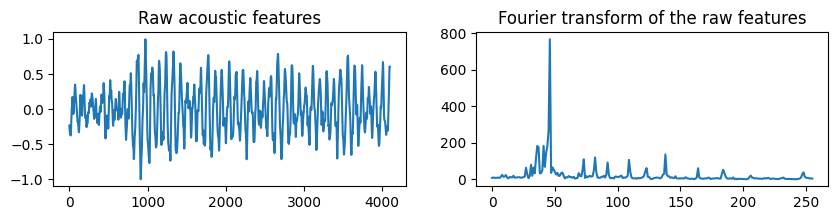

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(10,2))
ax[0].set_title('Raw acoustic features')
ax[0].plot(Xtrain[2])
ax[1].set_title('Fourier transform of the raw features')
ax[1].plot(np.abs(np.fft.rfft(Xtrain[2])[0:256])) # clip to 256 for the interval of 0Hz to 1kHz

What we just did was to take one of the files we have, show it's raw version and then the fourier transform. 
- **Left plot (Raw acoustic features):**  
  This shows the raw audio waveform values over time for one sample from `Xtrain[0]`. The x-axis represents the time steps or audio samples (ranging approximately from 0 to 4100), and the y-axis shows the amplitude of the audio signal at each time step (ranging from about -1 to 1). The waveform represents how the air pressure (sound wave) changes over time in the audio clip.

- **Right plot (Fourier Transform of the raw features):**  
  This shows the magnitude of the frequency components obtained by applying the Fast Fourier Transform (FFT) to the raw audio waveform.  
  The x-axis represents frequency bins (up to 256 in this clipped visualization), and the y-axis represents the amplitude (strength) of each frequency component. The FFT decomposes the time-domain signal into its frequency components, revealing which frequencies are present in the audio and their intensities.

**Summary:**  
- The raw waveform (left) shows how the sound varies over time.  
- The Fourier transform (right) shows the distribution of frequencies that make up the sound.  
These two views provide complementary insights into the audio: time domain vs frequency domain.


This means for each bin:
$$
f = \frac{\text{bin\_index} \times f_s}{N}
$$

where:  
- $ f $ is the frequency corresponding to the FFT bin,  
- $ \text{bin\_index} $ is the index of the FFT bin (0, 1, 2, \ldots),  
- $ f_s $ is the sampling rate (in Hz),  
- $ N $ is the FFT size (number of samples).

**Example:**  
If the sampling rate $ f_s = 16,000 $ Hz, FFT size $ N = 4,096 $, and the bin index is 50, then the frequency is:

$$
f = \frac{50 \times 16,000}{4,096} \approx 195.31 \text{ Hz}
$$


In [34]:
print("Xtrain shape:", Xtrain.shape)
print("Ytrain shape:", Ytrain.shape)
print("Xtest shape:", Xtest.shape)
print("Ytest shape:", Ytest.shape)

Xtrain shape: (62500, 4096)
Ytrain shape: (62500, 128)
Xtest shape: (10000, 4096)
Ytest shape: (10000, 128)


In [35]:
print("Number of active notes per sample (mean):", np.mean(np.sum(Ytrain, axis=1)))
print("Label sparsity:", np.mean(Ytrain))  # Proportion of 1s in labels

Number of active notes per sample (mean): 2.941808
Label sparsity: 0.022982875


What we just did was calculate the average number of active notes per sample. We achieved this by summing the columns of `Ytrain`, which is multi-one-hot encoded: each entry is `1` if a note is active in a given sample and `0` otherwise.

Before we keep on with the preprocessing of the data I am going to run some analysis on the frequencies we got.

In [74]:
print("Xtrain dtype:", Xtrain.dtype)
print("Ytrain dtype:", Ytrain.dtype)

Xtrain dtype: float32
Ytrain dtype: float64


In [77]:
print("Sample Xtrain[0]:", Xtrain[0])
print("Sample Ytrain[0]:", Ytrain[0])

Sample Xtrain[0]: [-0.01537969 -0.0221083  -0.03524511 ...  0.16404998  0.17494392
  0.19032362]
Sample Ytrain[0]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


We can also see the relationship between played and unplayed notes.

Unique labels and counts: {np.float64(0.0): np.int64(7816137), np.float64(1.0): np.int64(183863)}


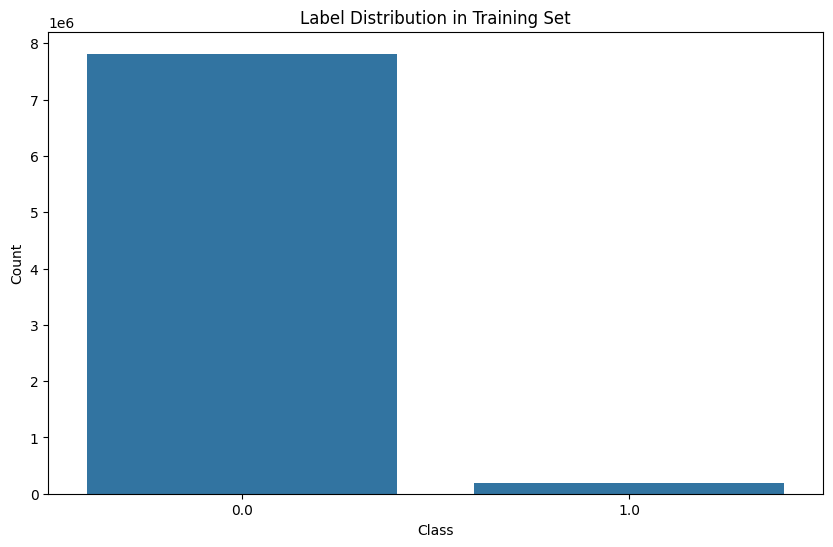

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Count unique labels in training set
unique, counts = np.unique(Ytrain, return_counts=True)
print("Unique labels and counts:", dict(zip(unique, counts)))

# Visualize label distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=Ytrain.ravel())
plt.title("Label Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [80]:
print("Xtrain stats - Mean:", np.mean(Xtrain), "Std:", np.std(Xtrain), 
      "Min:", np.min(Xtrain), "Max:", np.max(Xtrain))

Xtrain stats - Mean: -8.922857e-06 Std: 0.34472543 Min: -1.0 Max: 1.0


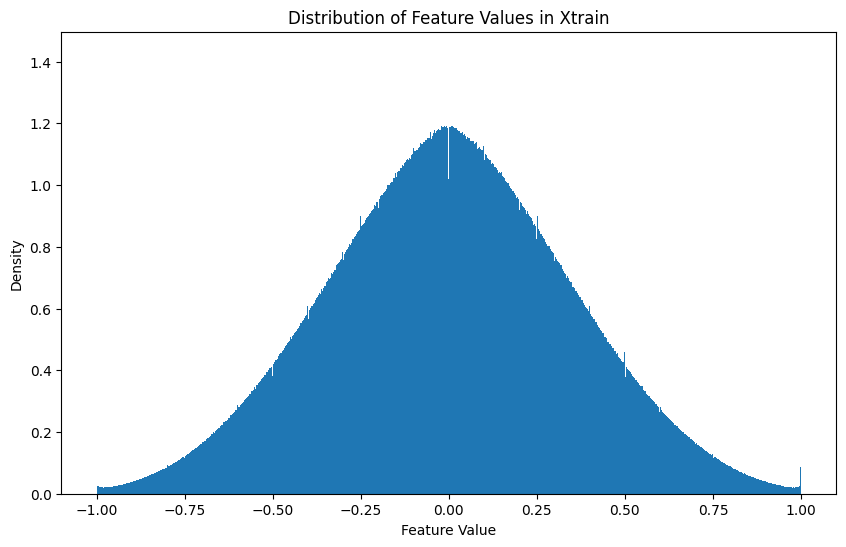

In [84]:
plt.figure(figsize=(10, 6))
plt.hist(Xtrain.flatten(), bins=1000, density=True)
plt.title("Distribution of Feature Values in Xtrain")
plt.xlabel("Feature Value")
plt.ylabel("Density")
plt.show()

What we just took a look at is the distribution of the features values in the Xtrain. We can easily see that they are equally distributed with a mean close to 0 and a standart deviation of 0.34 which is something very standard.

Firstly let us see how the labels in the `Ytrain` are distributed.

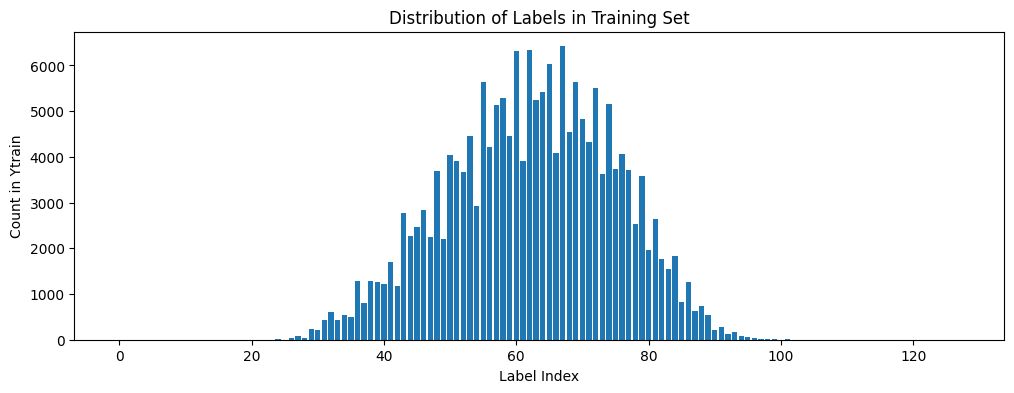

array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 4.000e+00,
       1.400e+01, 2.000e+00, 3.700e+01, 7.800e+01, 3.600e+01, 2.400e+02,
       2.120e+02, 4.310e+02, 6.040e+02, 4.410e+02, 5.320e+02, 4.980e+02,
       1.282e+03, 8.140e+02, 1.284e+03, 1.264e+03, 1.208e+03, 1.697e+03,
       1.172e+03, 2.770e+03, 2.260e+03, 2.464e+03, 2.844e+03, 2.256e+03,
       3.701e+03, 2.204e+03, 4.045e+03, 3.900e+03, 3.671e+03, 4.464e+03,
       2.927e+03, 5.642e+03, 4.214e+03, 5.144e+03, 5.295e+03, 4.446e+03,
       6.321e+03, 3.906e+03, 6.335e+03, 5.240e+03, 5.425e+03, 6.029e+03,
       4.074e+03, 6.416e+03, 4.553e+03, 5.635e+03, 4.835e+03, 4.326e+03,
       5.509e+03, 3.631e+03, 5.156e+03, 3.726e+03, 4.052e+03, 3.710e+03,
       2.532e+03, 3.590e+03, 1.971e+03, 2.651e+03, 

In [70]:
label_counts = Ytrain.sum(axis=0)
plt.figure(figsize=(12, 4))
plt.bar(range(len(label_counts)), label_counts)
plt.xlabel("Label Index")
plt.ylabel("Count in Ytrain")
plt.title("Distribution of Labels in Training Set")
plt.show()


In [73]:
print(f"Mean: {np.mean(label_counts):.2f}")
print(f"Median: {np.median(label_counts):.2f}")
print(f"Std dev: {np.std(label_counts):.2f}")
print(f"Number of labels with zero count: {(label_counts == 0).sum()}")
print(f"Total labels: {len(label_counts)}")


Mean: 1436.43
Median: 142.00
Std dev: 1965.24
Number of labels with zero count: 48
Total labels: 128


In [57]:
from scipy.stats import skew

label_counts = Ytrain.sum(axis=0)
asymmetry = skew(label_counts)

print(f"Skewness of label distribution: {asymmetry:.4f}")

if asymmetry > 1:
    print("The distribution is highly right-skewed (many rare labels).")
elif asymmetry > 0.5:
    print("The distribution is moderately right-skewed.")
elif asymmetry < -1:
    print("The distribution is highly left-skewed.")
elif asymmetry < -0.5:
    print("The distribution is moderately left-skewed.")
else:
    print("The distribution is approximately symmetric.")


Skewness of label distribution: 1.1143
The distribution is highly right-skewed (many rare labels).


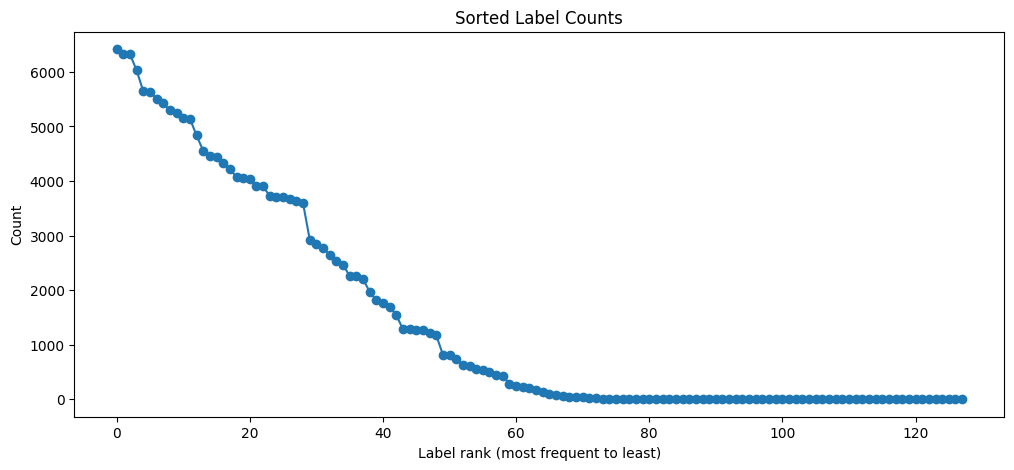

In [72]:
sorted_counts = np.sort(label_counts)[::-1]  # descending order

plt.figure(figsize=(12,5))
plt.plot(sorted_counts, marker='o')
plt.xlabel('Label rank (most frequent to least)')
plt.ylabel('Count')
plt.title('Sorted Label Counts')
plt.show()


## Preprocessing the data

To begin with, I am going to normalize the features so that they have a mean of 0 and a standard deviation of 1. This is an important preprocessing step when working with neural networks, as it helps improve convergence during training and ensures that the network treats all input features on a comparable scale. Without normalization, features with larger values could dominate the learning process, potentially leading to suboptimal results.

In [11]:
Xtrain_norm = (Xtrain - np.mean(Xtrain, axis=1, keepdims=True)) / np.std(Xtrain, axis=1, keepdims=True)
Xtest_norm = (Xtest - np.mean(Xtest, axis=1, keepdims=True)) / np.std(Xtest, axis=1, keepdims=True)

The next things we ought to do is to convert all this information into PyTorch tensors so that we can work with them. The library I am going to use is `PyTorch`.

In [12]:

# Convert to PyTorch tensors
Xtrain_tensor = torch.tensor(Xtrain_norm, dtype=torch.float32)
Ytrain_tensor = torch.tensor(Ytrain, dtype=torch.float32)
Xtest_tensor = torch.tensor(Xtest_norm, dtype=torch.float32)
Ytest_tensor = torch.tensor(Ytest, dtype=torch.float32)


We use a DataLoader with TensorDataset to efficiently feed our training data to the model in manageable batches, which helps optimize memory usage and accelerates training by enabling mini-batch gradient descent. Setting shuffle=True ensures that the model sees the data in a different order each epoch, which helps prevent overfitting and improves generalization.


In [13]:
# Create DataLoaders
train_dataset = TensorDataset(Xtrain_tensor, Ytrain_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

## Building a Neuro network

Before starting with the Neuro network I would like to to throught a brief introduction as to how Neuro networks work.

This model is a simple **feedforward neural network** designed for **multi-label classification**. It takes in **flattened input vectors of size 4096**, which are assumed to represent features extracted from audio (e.g., raw spectrogram frames).

## Model Architecture

- **Input layer:** 4096 features — represents the flattened audio input.
- **First hidden layer:** 512 neurons with **ReLU** activation  
  - This layer reduces the high-dimensional input to a more manageable representation while capturing important patterns.
- **Dropout layer:** with a probability of 0.3 applied after the first hidden layer  
  - Helps prevent overfitting by randomly deactivating neurons during training.
- **Second hidden layer:** 256 neurons with **ReLU** activation  
  - Further compresses and refines the learned features.
- **Dropout layer:** again with probability 0.3 applied after the second hidden layer.
- **Output layer:** 128 neurons — one for each possible note in the output  
  - Each neuron predicts the probability that the corresponding note is active.
- **Sigmoid activation:** applied to each output neuron  
  - Converts raw outputs into probabilities between 0 and 1, suitable for multi-label classification.

## Loss Function

We use `BCELoss` (Binary Cross-Entropy Loss) because this is a **multi-label binary classification problem** —  
each note can independently be either active (1) or inactive (0), so the model predicts a probability for each note.

This architecture balances complexity and efficiency, providing enough capacity to learn meaningful audio feature patterns while avoiding overfitting through dropout regularization.


Epoch 1/10, Train Loss: 0.0888
Epoch 2/10, Train Loss: 0.0701
Epoch 3/10, Train Loss: 0.0672
Epoch 4/10, Train Loss: 0.0656
Epoch 5/10, Train Loss: 0.0644
Epoch 6/10, Train Loss: 0.0634
Epoch 7/10, Train Loss: 0.0628
Epoch 8/10, Train Loss: 0.0622
Epoch 9/10, Train Loss: 0.0616
Epoch 10/10, Train Loss: 0.0613


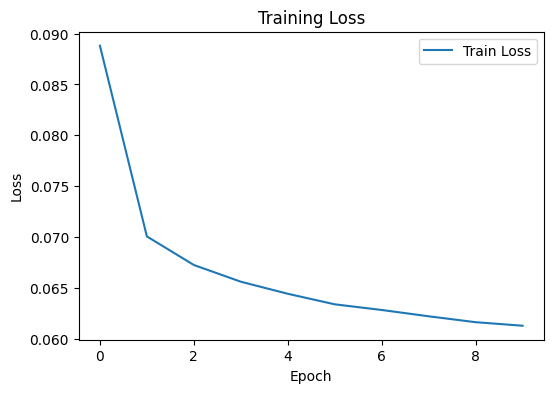

In [16]:
import torch.nn as nn
import torch.optim as optim

# Define model
class TranscriptionModel(nn.Module):
    def __init__(self, input_size=4096, hidden_size1=512, hidden_size2=256, output_size=128):
        super(TranscriptionModel, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.output = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.dropout1(x)
        x = self.relu2(self.layer2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.output(x))
        return x

# Initialize model, loss, and optimizer
model = TranscriptionModel()
criterion = nn.BCELoss()  # Binary cross-entropy for multi-label
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_losses = []
# valid_losses = []  # Uncomment if using validation set

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device) # trying to use the GPU is available
        optimizer.zero_grad() # not using some features that are not needed for training
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}")


# Plot training history
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='Train Loss')
# plt.plot(valid_losses, label='Validation Loss')  # Uncomment if using validation
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluation


In multi-label classification tasks like music transcription, where the model predicts which notes are active in an audio frame, accuracy alone is often insufficient. This is because most notes are inactive in any given frame, so a naive model could predict all zeros and still get high accuracy.

To better understand model performance, we use the following metrics:

| Metric    | Description                                                                                           | Relevance in Music Transcription                          |
|-----------|---------------------------------------------------------------------------------------------------|----------------------------------------------------------|
| Precision | The ratio of correctly predicted active notes to all notes predicted as active.                   | Measures how many predicted notes are actually correct.  |
| Recall    | The ratio of correctly predicted active notes to all true active notes.                           | Measures how well the model finds all active notes.       |
| F1-Score  | The harmonic mean of Precision and Recall, balancing both metrics.                               | Useful when we want a balance between detecting notes and avoiding false alarms. |
| Accuracy  | The ratio of correct predictions (both active and inactive) to all predictions.                   | Can be misleading in imbalanced data like note activity. |

**Why these matter for us:**  
In music transcription, missing an active note (low recall) means the model fails to detect a real sound. Predicting too many notes that aren't actually played (low precision) means the transcription contains false notes. The F1-score helps balance these two.


In [25]:
model.eval()
with torch.no_grad():
    Xtest_tensor = Xtest_tensor.to(device)
    Ypred = (model(Xtest_tensor) > 0.5).cpu().numpy()

f1 = f1_score(Ytest, Ypred, average='micro')
print("Test F1-score:", f1)

Test F1-score: 0.35835092448943257


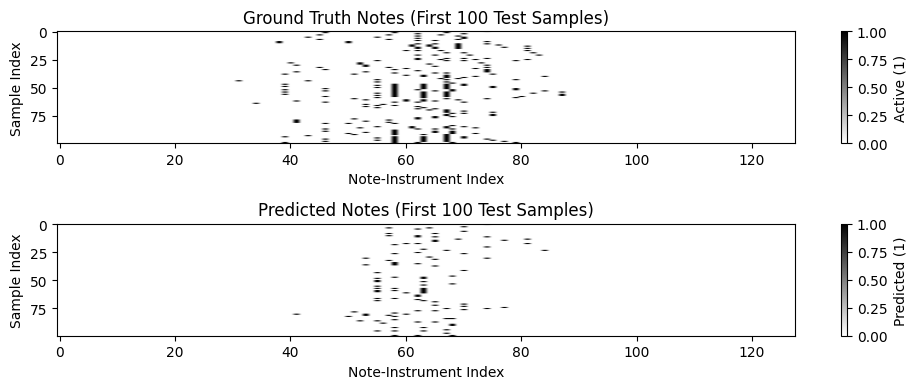

In [26]:
plt.figure(figsize=(10, 4))
plt.subplot(2, 1, 1)
plt.imshow(Ytest[:100], aspect='auto', cmap='binary')
plt.title("Ground Truth Notes (First 100 Test Samples)")
plt.xlabel("Note-Instrument Index")
plt.ylabel("Sample Index")
plt.colorbar(label="Active (1)")
plt.subplot(2, 1, 2)
plt.imshow(Ypred[:100], aspect='auto', cmap='binary')
plt.title("Predicted Notes (First 100 Test Samples)")
plt.xlabel("Note-Instrument Index")
plt.ylabel("Sample Index")
plt.colorbar(label="Predicted (1)")
plt.tight_layout()
plt.show()

## Trying a CNN model

In this section I am going to do some modification such as susing a CNN and also uploading the data in the form of spectograms so

In [39]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

import numpy as np
import librosa


def waveform_to_mel_spectrogram(waveforms, sr=44100, n_mels=64, n_fft=2048, hop_length=1024):
    specs = []
    for waveform in tqdm(waveforms, desc="Converting waveforms to mel spectrograms"):
        mel_spec = librosa.feature.melspectrogram(y=waveform, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
        mel_db = librosa.power_to_db(mel_spec, ref=np.max)
        specs.append(mel_db)
    return np.array(specs)

# Example: Convert your datasets
Xtrain_spec = waveform_to_mel_spectrogram(Xtrain)
Xvalid_spec = waveform_to_mel_spectrogram(Xvalid)
Xtest_spec = waveform_to_mel_spectrogram(Xtest)

print("Spectrogram shapes:", Xtrain_spec.shape, Xvalid_spec.shape, Xtest_spec.shape)


Converting waveforms to mel spectrograms: 100%|█████████████████████████████████| 10000/10000 [00:23<00:00, 420.27it/s]

Spectrogram shapes: (62500, 64, 5) (10000, 64, 5) (10000, 64, 5)


In [49]:
class SpectrogramDataset(Dataset):
    def __init__(self, specs, labels):
        # specs shape: (N, n_mels, time_frames)
        self.specs = torch.tensor(specs, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.specs)

    def __getitem__(self, idx):
        # Add channel dimension: CNN expects (C, H, W)
        x = self.specs[idx].unsqueeze(0)
        y = self.labels[idx]
        return x, y

train_dataset = SpectrogramDataset(Xtrain_spec, Ytrain)
valid_dataset = SpectrogramDataset(Xvalid_spec, Yvalid)
test_dataset = SpectrogramDataset(Xtest_spec, Ytest)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)


One of the important things that we ought to look at here is the fact.

In [50]:
class SimpleCNN(nn.Module):
    def __init__(self, n_mels, time_frames, output_size=128):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2)

        # Calculate flattened size after two poolings
        h = n_mels // 4
        w = time_frames // 4
        self.fc1 = nn.Linear(32 * h * w, 128)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, output_size)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

n_mels, time_frames = Xtrain_spec.shape[1], Xtrain_spec.shape[2]
model = SimpleCNN(n_mels, time_frames).to('cuda' if torch.cuda.is_available() else 'cpu')


In [54]:

device = next(model.parameters()).device
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
valid_losses = []

def train_epoch(model, loader):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

def eval_epoch(model, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

for epoch in range(10):
    train_loss = train_epoch(model, train_loader)
    valid_loss = eval_epoch(model, valid_loader)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

# Plotting loss curves
plt.plot(range(1, 11), train_losses, label='Train Loss')
plt.plot(range(1, 11), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

save_path = os.path.expanduser("~/Documents/loss_curve.png") # Saving the photo
plt.savefig(save_path)

plt.show()

# Calculate F1 on validation set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in valid_loader:
        x = x.to(device)
        out = model(x)
        preds = torch.sigmoid(out).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(y.numpy())

import numpy as np
all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)

# Assuming binary classification, threshold at 0.5
pred_labels = (all_preds >= 0.5).astype(int)

f1 = f1_score(all_labels, pred_labels, average='macro',zero_division=0)
print(f'Validation F1 score: {f1:.4f}')



KeyboardInterrupt



## To dos
- add some analysis on the frequencies i got and compare the two training i got.

Validation F1 score: 0.0936
